# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [18]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

In [19]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [20]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

In [21]:
import hvplot.pandas

# Import Data

In [22]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [55]:
# Getting the data from the top 10 expensive neighbourhoods
neighbourhood_data = to_data.reset_index()
clean_neighbourhood_data = neighbourhood_data.drop(columns = ['year'])
clean_neighbourhood_data = clean_neighbourhood_data.sort_values(['neighbourhood'])
average_neighbourhood_data = clean_neighbourhood_data.groupby(['neighbourhood']).mean()


high_average_neighbourhood_data = average_neighbourhood_data.sort_values(['average_house_value'], ascending=False)
top10_neighbourhoods = high_average_neighbourhood_data.reset_index()
top10_neighbourhoods_value = top10_neighbourhoods.nlargest(10, 'average_house_value')
top10_neighbourhoods_value = top10_neighbourhoods_value.iloc[:, [0,9]]

toronto_neighbourhood_data = to_data.groupby('year').sum()
dwelling_types_per_year = toronto_neighbourhood_data.drop(
    columns=['average_house_value','shelter_costs_owned','shelter_costs_rented'])

# Calculate the mean number of dwelling types units per year
data_per_year_per_neighbourhood = to_data.groupby(['year','neighbourhood']).mean()
dwelling_per_year_per_neighbourhood = data_per_year_per_neighbourhood.drop(
    columns=['average_house_value','shelter_costs_owned','shelter_costs_rented']).copy()
dwelling_per_year_per_neighbourhood.reset_index(inplace=True)

dwelling_per_year_per_neighbourhood.set_index('year', inplace = True)


avg_house_values_neighbourhood = to_data[['neighbourhood','average_house_value']].groupby(['year','neighbourhood']).mean()

# Calculate the average monthly shelter costs for owned and rented dwellings
avg_house_value = to_data[['average_house_value']].groupby('year').mean()

sorted_coordinates = df_neighbourhood_locations.sort_values(['neighbourhood']).set_index(['neighbourhood'])

# Neighbourhoood coordinates
neighbourhood_coordinates = pd.concat(
    [sorted_coordinates, average_neighbourhood_data], axis = 1, join = "inner").reset_index()

# Average house value per year
neighbourhood_value_per_year = to_data.sort_values(['year','neighbourhood'])
neighbourhood_value_peryear_plot = neighbourhood_value_per_year.reset_index()



,single_detached_house,apartment_five_storeys_plus,movable_dwelling,semi_detached_house,row_house,duplex,apartment_five_storeys_less,other_house
year,,,,,,,,
2001,300930,355015,75,90995,52355,23785,116900,3040
2006,266860,379400,165,69430,54690,44095,162850,1335
2011,274940,429220,100,72480,60355,44750,163895,2165
2016,269680,493270,95,71200,61565,48585,165575,2845


### Panel Visualization Functions

In [50]:
# Define Panel visualization functions
# Neighbourhoood map
def neighbourhood_map():
    map = px.scatter_mapbox(
        neighbourhood_coordinates,
        lat= "lat",
        lon= "lon",
        title = "Average House Values in Toronto",
        color= "average_house_value",
        size= "average_house_value",
        hover_name = "neighbourhood",
        hover_data = ["single_detached_house", "apartment_five_storeys_plus", "movable_dwelling", 
                      "semi_detached_house", "row_house", "duplex", "apartment_five_storeys_less", 
                      "other_house", "shelter_costs_owned", "shelter_costs_rented"],  
        zoom = 8
    )
    neighbourhood_map_plot = pn.pane.Plotly(map)
    return neighbourhood_map_plot

# Dwelling types per year
def create_bar_chart(data, title, xlabel, ylabel, color):
    fig = plt.figure()
    data.plot(kind="bar", color = color, rot = 90)
    plt.title(title, fontdict={'fontsize': 12, 'fontweight': 'bold'})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    create_bar_chart(
        dwelling_types_per_year.iloc[0], 
        'Dwelling Types in Toronto in 2001', 
        '2001', 
        'Dwelling Type Units', 
        'r' 
    )
    create_bar_chart(
        dwelling_types_per_year.iloc[1], 
        'Dwelling Types in Toronto in 2006', 
        '2006', 
        'Dwelling Type Units', 
        'b' 
    )
    create_bar_chart(
        dwelling_types_per_year.iloc[2], 
        'Dwelling Types in Toronto in 2011', 
        '2011', 
        'Dwelling Type Units', 
        'y' 
    )
    create_bar_chart(
        dwelling_types_per_year.iloc[3], 
        'Dwelling Types in Toronto in 2016', 
        '2016', 
        'Dwelling Type Units', 
        'm' 
    )    
    
    dwelling_types_toronto = pn.pane.Plotly(map)
    return dwelling_types_toronto

# Owned and rented Dwellings
def create_line_chart(data, title, xlabel, ylabel, color):
    data.plot(kind="line", color = color)
    plt.title(title, fontdict={'fontsize': 12, 'fontweight': 'bold'})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Line chart for owned dwellings
    create_line_chart(
        avg_monthly_shelter.loc[:, ['shelter_costs_owned']], 
        "Average Monthly Shelter Cost for Owned Dwellings in Toronto",
        "Year",
        "Avg Monthly Shelter Costs",
        "b"
    )  

    # Line chart for rented dwellings
    create_line_chart(
        avg_monthly_shelter.loc[:, ['shelter_costs_rented']],
        "Average Monthly Shelter Cost for Rented Dwellings in Toronto",
        "Year",
        "Avg Monthly Shelter Costs",
        "y"
    )

    avg_monthly_shelter_costs = pn.pane.Plotly(map)
    return avg_monthly_shelter_costs


# Average House values per year for all
def average_house_value():
    avg_house_value.plot(kind = "line", color = 'c', title = "Average House Value in Toronto")
    plt.xlabel("Year")
    plt.ylabel("Avg. House Value")

    avg_house_value_p_year = pn.pane.Plotly(map)
    return avg_house_value_p_year

# plot avg house values per year per neighbourhood
def average_house_value_per_year():

    fig = px.bar(
        neighbourhood_value_peryear_plot,
        title="Average House Values in Toronto per Neighbourhood",
        x= "neighbourhood", 
        y= "average_house_value", 
        color= "average_house_value", 
        facet_row= "year",
        labels={"average_house_value": "Avg. House Value",
                         "neighbourhood": "Neighbourhood"},
        width = 1000,
        height = 1000,
    )

    fig.update_layout( 
        legend_title= "Avg. House Value",
        font = dict(size=10))
    fig.show()
    
    avg_house_value_per_year = pn.pane.Plotly(map)
    return avg_house_value_per_year

# Average house value by neighbourhood
def average_value_by_neighbourhood():
    avg_house_values_neighbourhood.hvplot.line(groupby='neighbourhood', xlabel = "Year", ylabel = "Avg. House Value")    

    avg_house_values_by_neighbourhood = pn.pane.Plotly(map)
    return avg_house_values_by_neighbourhood


# Number of dwelling types per year
def number_dwelling_types():
    dwelling_per_year_per_neighbourhood.hvplot.bar(
        groupby='neighbourhood', 
        rot = 90, 
        frame_height = 250, 
        frame_width=500, 
        xlabel="Year", 
        ylabel = "Dwelling Type Units"
    )

    number_of_dwelling_types = pn.pane.Plotly(map)
    return number_of_dwelling_types



def top_most_expensive_neighbourhoods():   
    top10_neighbourhoods_value.hvplot.bar(
        title = "Top 10 Expensive Neighbourhoods in Toronto", 
        ylabel = "Avg. House Value", 
        xlabel = "Neighbourhood", 
        frame_height = 250, 
        frame_width=500, 
        rot=90
    )
    top10_neighbourhood_value_toronto = pn.pane.Plotly(map)
    return top10_neighbourhood_value_toronto
    
    
def sunburts_cost_analysis(): 
    fig =px.sunburst(
        highest_neighbourhood_value,
        path = ['year', 'neighbourhood'],
        hover_data = ['shelter_costs_rented'],
        values='average_house_value',
        color = 'shelter_costs_owned',
        color_continuous_scale = 'ice',
        title = 'Cost Analysis of Most Expensive Neighbourhoods in Toronto per Year'
    )

    fig.show()

    cost_analysis_neighbourhood = pn.pane.Plotly(map)
    return cost_analysis_neighbourhood

# Neighbourhood value per year plot



## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [ ]:
# Create a Title for the Dashboard
dashboard_title = pn.pane.Markdown('   Real Estate Analysis for Toronto - 2001 to 2016  ')



# Define a welcome text
welcome_text = pn.pane.Markdown(' This dashboard includes a visual analysis of historical house values, dwelling types per </br> neighbourhood and dwelling costs in Toronto, Ontario according to census data from 2001 to 2016. Navigation is possible through the above tabs to delve into more details on the real estate data over this time period')

welcome_column = pn.Column(dashboard_title, welcome_text, neighbourhood_map())


# Create panels to structure the layout of the dashboard
neighbourhood_column = pn.Column(average_value_by_neighbourhood(),number_dwelling_types(), average_house_value_per_year())

top_expensive_neighbourhoods_column = pn.Column(top_most_expensive_neighbourhoods(),sunburts_cost_analysis())

yearly_market_analysis_column = pn.Column(create_bar_chart(data, title, xlabel, ylabel, color))

shelter_cost_house_value_column = pn.Column(average_house_value())


# Create tabs
dashboard_tabs = pn.Tabs(
    ("Welcome", welcome_column), 
    ("Yearly Market Analysis", yearly_market_analysis_column), 
    ("Shelter Costs vs. House Value", shelter_cost_house_value_column), 
    ("Neighbourhood Analysis", neighbourhood_column), 
    ("Top Expensive Neighbourhoods", top_expensive_neighbourhoods_column)
)


## Serve the Panel Dashboard

In [ ]:
dashboard_tabs.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [53]:
#neighbourhood_map().show()

Launching server at http://localhost:52061


In [58]:
create_bar_chart(data, title, xlabel, ylabel, color)

# Bar chart for 2001
create_bar_chart(dwelling_types_per_year.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# Bar chart for 2006
# create_bar_chart(dwelling_types_per_year.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# Bar chart for 2011
# create_bar_chart(dwelling_types_per_year.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# Bar chart for 2016
# create_bar_chart(dwelling_types_per_year.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

NameError: name 'data' is not defined

In [11]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

ValueError: Plotly pane does not support objects of type 'type'.

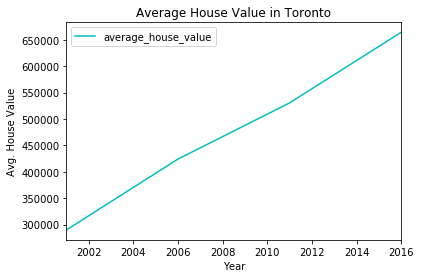

In [56]:
# average_house_value()

In [13]:
# average_value_by_neighbourhood()

In [14]:
# number_dwelling_types()

In [15]:
# average_house_value_snapshot()

In [16]:
# top_most_expensive_neighbourhoods()

In [17]:
# sunburts_cost_analysis()